# Classification - Workshop

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

## A. EXERCISE: Classify thermal/shocked objects

### TASK A.1: Choose 3 diagnostics to run the classification on

### Loading and setting up the data

In [15]:
# CREATING DATA STRUCTURE

# > Loading the emission line data and classifications:

PATH_lines_data = "data/stellar_lines.txt" 

data = np.genfromtxt(PATH_lines_data)
# The data file is organized in 138799 lines (i.e. different objects), and 12 columns

age              = data[:,1]  # object age
Q                = data[:,2]  #
NII_diagnostic   = data[:,3]  # log10 ( NII  / H_alpha )
SII_diagnostic   = data[:,4]  # log10 ( SII  / H_alpha )
OII_diagnostic   = data[:,5]  # log10 ( OII  / H_beta  )
OI_diagnostic    = data[:,6]  # log10 ( OI   / H_alpha )
OIf_diagnostic   = data[:,7]  # log10 ( OIf  / H_beta  )
OIIf_diagnostic  = data[:,8]  # log10 ( OIIf / H_beta  )
OIII_diagnostic  = data[:,9]  # log10 ( OIII / H_beta  )

labels = np.genfromtxt(PATH_lines_data, delimiter=' ', usecols=0, dtype=str)
# reading labels from first column
# Emission class labelling scheme:
#   0 <-> thermal
#   1 <-> shocked

# Dictionary containg class name and associated label:
from collections import OrderedDict
classes = OrderedDict()
classes["thermal"] = 0
classes["shocked"] = 1

labels = [int(float(label)) for label in labels]
# converting labels from strings to integers

# > Organizing data in an analysis-ready fashion:
X = np.stack((OIII_diagnostic,
              NII_diagnostic,
              SII_diagnostic,
              OII_diagnostic,
              OI_diagnostic,
              OIf_diagnostic,
              OIIf_diagnostic),axis=-1)
y = labels

print('Sample shape:')
print("_____________________________________")
print('  X  | ' + str(X.shape))
print('     | ' + str(X.shape[0]) + ' sammples x ' + str(X.shape[1]) + ' diagnostics' )
print("-----|-------------------------------")
print('  y  | ' + str(len(y)) + ' labels')

Sample shape:
_____________________________________
  X  | (8080, 7)
     | 8080 sammples x 7 diagnostics
-----|-------------------------------
  y  | 8080 labels


### Visualizing the data

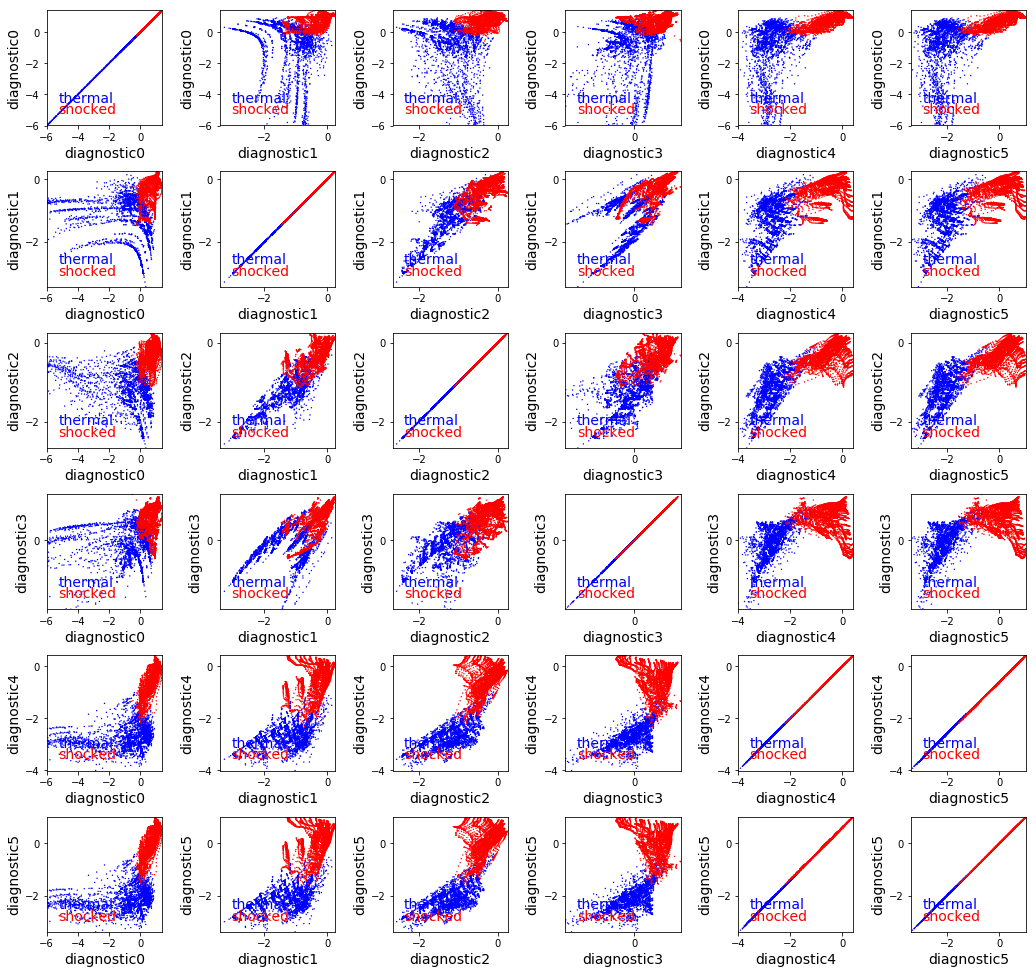

In [62]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors

# Creating a colormap where:
#   blue <-> thermal
#   red  <-> shocked
cmap = mpl.colors.ListedColormap(['blue','red'])

# Remeber that the sample X is organized as:
#  X[:,0] <-> diagnostic 1
#  X[:,1] <-> diagnostic 2
#  X[:,2] <-> ...


# PLOT EACH DIAGNOSITCS AGAINST THE OTHERS

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.4, left=0.1, right=0.95, wspace=0.5)

plot_counter= 0
n_rows = int(X.shape[1]) - 1
n_cols = int(X.shape[1]) - 1

for j in range(n_cols):
    for i in range(n_rows):


            plot_counter+=1
            xlim = [np.min(X[:, i]),np.max(X[:, i])]
            ylim = [np.min(X[:, j]),np.max(X[:, j])]

            ax = fig.add_subplot(n_rows, n_cols, plot_counter)
            im = ax.scatter(X[:, i], X[:, j], c=y, s=2, lw=0, cmap=cmap, zorder=2)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.xaxis.set_major_locator(plt.MultipleLocator(2))
            ax.yaxis.set_major_locator(plt.MultipleLocator(2))
            ax.set_xlabel('diagnostic' + str(i), fontsize=14)
            ax.set_ylabel('diagnostic' + str(j), fontsize=14)

            # legend:
            ax.text(0.1,0.20, "thermal", color='blue', transform=ax.transAxes, fontsize=14)
            ax.text(0.1,0.10, "shocked", color='red',  transform=ax.transAxes, fontsize=14)


plt.show()

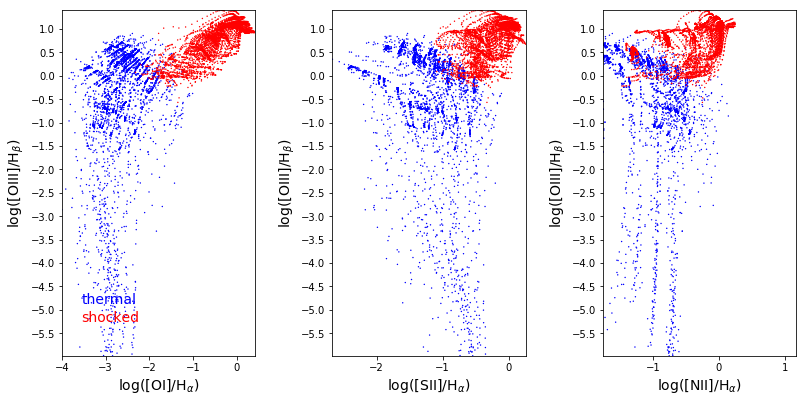

In [60]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors

# Creating a colormap where:
#   blue <-> thermal
#   red  <-> shocked
cmap = mpl.colors.ListedColormap(['blue','red'])

# Remeber that the sample X is organized as:
#  X[:,0] <-> diagnostic 1
#  X[:,1] <-> diagnostic 2
#  X[:,2] <-> ...


# PLOT SOME DIAGNOSITCS

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ylim = [np.min(X[:, 0]),np.max(X[:, 0])]

# > left plot

xlim = [np.min(X[:, 4]),np.max(X[:, 4])]

ax = fig.add_subplot(131)
im = ax.scatter(X[:, 4], X[:, 0], c=y, s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([OI]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟIII]/H$_{β})$', fontsize=14)

# legend:
ax.text(0.1,0.15, "thermal", color='blue', transform=ax.transAxes, fontsize=14)
ax.text(0.1,0.10, "shocked", color='red',  transform=ax.transAxes, fontsize=14)

# > central plot

xlim = [np.min(X[:, 2]),np.max(X[:, 2])]

ax = fig.add_subplot(132)
im = ax.scatter(X[:, 2], X[:, 0], c=y[:], s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([SII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟIII]/H$_{β})$', fontsize=14)

# > right plot

xlim = [np.min(X[:, 3]),np.max(X[:, 3])]

ax = fig.add_subplot(133)
im = ax.scatter(X[:, 1], X[:, 0], c=y[:], s=2, lw=0, cmap=cmap, zorder=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_xlabel('log([NII]/H$_{α})$', fontsize=14)
ax.set_ylabel('log([ΟIII]/H$_{β})$', fontsize=14)

plt.show()

In [23]:
N_HII=4268
N_SNR=3812
N_data = N_HII + N_SNR

X_data = np.zeros((N_data, 9))
X_SII_OI = np.zeros((N_data, 2))
X_SII_OIII = np.zeros((N_data, 2))
X_SII_OII = np.zeros((N_data, 2))
X_SII_NII = np.zeros((N_data, 2))
X_NII_OIII = np.zeros((N_data, 2))
X_NII_OII = np.zeros((N_data, 2))
X_NII_OI = np.zeros((N_data, 2))
X_OIf_OIIf = np.zeros((N_data, 2))
X_OI_OII = np.zeros((N_data, 2))
X_OI_OIII = np.zeros((N_data, 2))
X_OII_OIII = np.zeros((N_data, 2))
X_OIf_OI = np.zeros((N_data, 2))
X_OIf_SII = np.zeros((N_data, 2))
X_SII_OIIf = np.zeros((N_data, 2))
X_OI_OIIf = np.zeros((N_data, 2))
X_NII_OIf = np.zeros((N_data, 2))
X_NII_OIIf = np.zeros((N_data, 2))
X_OIf_OIII = np.zeros((N_data, 2))
X_OIf_OII = np.zeros((N_data, 2))
X_OIIf_OIII = np.zeros((N_data, 2))

fop =  open('data/all_models', 'r') #age Q NII/Ha SII/Ha OII/Hb OI/Ha OIf/Hb OIIf/Hb OIII/Hb
for i, lines in enumerate(fop.readlines()):
	line = lines.split(' ')
	X_data[i][0], X_data[i][1], X_data[i][2],X_data[i][3], X_data[i][4], X_data[i][5],X_data[i][6], X_data[i][7], X_data[i][8] = line[0], line[1], line[2],line[3], line[4], line[5],line[6], line[7], line[8]
	X_SII_OI[i][0], X_SII_OI[i][1]= line[3], line[5]
	X_SII_OIII[i][0], X_SII_OIII[i][1]= line[3], line[8]
	X_SII_OII[i][0], X_SII_OII[i][1]= line[3], line[4]
	X_SII_NII[i][0], X_SII_NII[i][1]= line[3], line[2]
	X_NII_OIII[i][0], X_NII_OIII[i][1]= line[2], line[8]
	X_NII_OII[i][0], X_NII_OII[i][1]= line[2], line[4]
	X_NII_OI[i][0], X_NII_OI[i][1]= line[2], line[5]
	X_OIf_OIIf[i][0], X_OIf_OIIf[i][1]= line[6], line[7]
	X_OI_OII[i][0], X_OI_OII[i][1]= line[5], line[4]
	X_OI_OIII[i][0], X_OI_OIII[i][1]= line[5], line[8]
	X_OII_OIII[i][0], X_OII_OIII[i][1]= line[4], line[8]
	X_OIf_OI[i][0], X_OIf_OI[i][1] = line[6], line[5]
	X_OIf_SII[i][0], X_OIf_SII[i][1] = line[6], line[3]
	X_SII_OIIf[i][0], X_SII_OIIf[i][1]= line[3], line[7]
	X_OI_OIIf[i][0], X_OI_OIIf[i][1]= line[5], line[7]
	X_NII_OIf[i][0], X_NII_OIf[i][1]= line[2], line[6]
	X_NII_OIIf[i][0], X_NII_OIIf[i][1]= line[2], line[7]
	X_OIf_OIII[i][0], X_OIf_OIII[i][1]= line[6], line[8]
	X_OIf_OII[i][0], X_OIf_OII[i][1]= line[6], line[4]
	X_OIIf_OIII[i][0], X_OIIf_OIII[i][1]= line[7], line[8]

In [24]:
HII_age=[]
HII_Q=[]
HII_NII=[]
HII_SII=[]
HII_OII=[]
HII_OI=[]
HII_OIf=[]
HII_OIIf=[]
HII_OIII=[]

SNR_B=[]
SNR_V=[]
SNR_NII=[]
SNR_SII=[]
SNR_OII=[]
SNR_OI=[]
SNR_OIf=[]
SNR_OIIf=[]
SNR_OIII=[]

for i in range(N_HII):
	HII_age.append(X_data[i][0])
	HII_Q.append(X_data[i][1])
	HII_NII.append(X_data[i][2])
	HII_SII.append(X_data[i][3])
	HII_OII.append(X_data[i][4])
	HII_OI.append(X_data[i][5])
	HII_OIf.append(X_data[i][6])
	HII_OIIf.append(X_data[i][7])
	HII_OIII.append(X_data[i][8])


for i in range(N_SNR):
	SNR_B.append(X_data[N_HII+i][0])
	SNR_V.append(X_data[N_HII+i][1])
	SNR_NII.append(X_data[N_HII+i][2]) 
	SNR_SII.append(X_data[N_HII+i][3]) 
	SNR_OII.append(X_data[N_HII+i][4]) 
	SNR_OI.append(X_data[N_HII+i][5]) 
	SNR_OIf.append(X_data[N_HII+i][6]) 
	SNR_OIIf.append(X_data[N_HII+i][7]) 
	SNR_OIII.append(X_data[N_HII+i][8]) 


In [25]:
class_labels = np.append((np.zeros(N_HII)), (np.ones(N_SNR)))
yar=np.array([class_labels])
yint=yar.astype(int)
yt=yar.T
ytint=yt.astype(int)
y=class_labels.astype(np.integer)
	
clf_poly_2d = SVC(kernel='poly', gamma=0.4, degree=3, coef0=1.0, class_weight=None) #coef0=-0.5,
clf_poly_2d.fit(X_OI_OIII, y)
y_pred_poly_2d = clf_poly_2d.predict(X_OI_OIII)

predictions_poly_2d=[]
predictions_poly_2d.append(y_pred_poly_2d)
completeness_poly_X_OI_OIII, contamination_lin_X_OI_OIII = completeness_contamination(predictions_poly_2d, y)
print(completeness_poly_X_OI_OIII, contamination_lin_X_OI_OIII, clf_poly_2d.intercept_)
x_sv_poly_2d=[]
y_sv_poly_2d=[]
coef_poly_2d=[]

x_sv_poly_2d=np.array(clf_poly_2d.support_vectors_[:,0])
y_sv_poly_2d=np.array(clf_poly_2d.support_vectors_[:,1])

coef_poly_2d=clf_poly_2d.dual_coef_.T
apo1=[]
apo2=[]
apo3=[]
apo4=[]
apo5=[]
apo6=[]
apo7=[]
apo8=[]
apo9=[]
apo10=[]
gam=0.4
coef0=1.0
for i in range(len(x_sv_poly_2d)):
	apo1.append(coef_poly_2d[i]*(gam**3)*(x_sv_poly_2d[i])**3)
	apo2.append(coef_poly_2d[i]*(gam**3)*3*(x_sv_poly_2d[i])**2*(y_sv_poly_2d[i]))
	apo3.append(coef_poly_2d[i]*(gam**3)*3*(x_sv_poly_2d[i])*(y_sv_poly_2d[i])**2)
	apo4.append(coef_poly_2d[i]*(gam**3)*(y_sv_poly_2d[i])**3)
	apo5.append(coef_poly_2d[i]*(gam**2)*3*(x_sv_poly_2d[i])**2*coef0)
	apo6.append(coef_poly_2d[i]*(gam**2)*6*coef0*(x_sv_poly_2d[i])*(y_sv_poly_2d[i]))
	apo7.append(coef_poly_2d[i]*(gam**2)*3*(y_sv_poly_2d[i])**2*coef0)
	apo8.append(coef_poly_2d[i]*(gam)*3*(x_sv_poly_2d[i])*coef0**2)
	apo9.append(coef_poly_2d[i]*(gam)*3*(y_sv_poly_2d[i])*coef0**2)
	apo10.append(coef_poly_2d[i]*coef0**3)
print('vale despues')
apol1=sum(apo1)
apol2=sum(apo2)
apol3=sum(apo3)
apol4=sum(apo4)
apol5=sum(apo5)
apol6=sum(apo6)
apol7=sum(apo7)
apol8=sum(apo8)
apol9=sum(apo9)
apol10=sum(apo10)


[0.98767051] [0.01155159] [2.71013209]
vale despues


/usr/local/lib/python3.4/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.4/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


SNRs_right,SNRs_left,HII_right,HII_left 3765 47 44 4224
completeness_poly_OI_OIII, contamination_poly_OI_OIII = [0.98767051] [0.01155159]


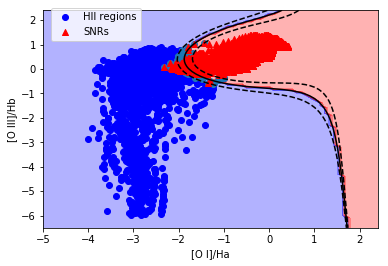

In [26]:

from matplotlib.font_manager import FontProperties
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg

import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn import metrics

#from astroML.datasets import fetch_rrlyrae_mags
from astroML.decorators import pickle_results
#from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from sklearn import svm
from sklearn.svm import SVR
from mlxtend.plotting import plot_decision_regions
from astroML.utils import completeness_contamination
import sympy as sy
from sympy.solvers import solve
import math
from sympy.utilities import lambdify
from sympy.abc import x, y, z, a, b
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from numpy import *
from scipy.optimize import *
import matplotlib

from sympy.abc import x, y
'''
g = lambda x,y: (apol1*x**3  + apol2*x**2*y + apol3*x*y**2 + apol4*y**3 + apol5*x**2 + apol6*x*y + apol7*y**2 + apol8*x + apol9*y + 
apol10 + clf_poly_2d.intercept_ )
print apol1, apol2, apol3,apol4, apol5,apol6, apol7, apol8, apol9, apol10, clf_poly_2d.intercept_ 
'''
with open('apols_OI_OIII', "w") as out:
	print(apol1,'x**3', apol2,'x**2y', apol3,'xy**2', apol4,'y**3', apol5,'x**2', 
	apol6,'xy', apol7,'y**2', apol8,'x', apol9,'y', apol10, clf_poly_2d.intercept_,file=out)
#f = lambda x,y: (0.465*x**3 -0.245*x**2*y - 0.432*x**2 + 1.067*x*y**2 -0.887*x*y - 0.701*x+ 0.049*y**3  - 
#      1.610*y**2  + 2.096*y + 2.71)




'''	
fy_poly_2d=solve(f_poly_2d(x,y), y, set=True)
print 'fy_lin_2d_inhom=', fy_poly_2d
#f1x=(list(fy_poly_2d[1])[0])
#f2x=(list(fy_poly_2d[1])[1])
#fx_poly_2d1 = lambdify((x),f1x)
#fx_poly_2d2 = lambdify((x),f2x)

f1= lambda x: (-0.275458859142031*x + 1.86297823648487e-15*(-5.55039981388443e+28*x**2 - 4.57589303362045e+29*x - 
9.66496232269578e+29)**0.5 + 1.30173358220258)
'''


r=[x,y]
#f= lambda x,y: list(((np.dot(clf_poly_2d.support_vectors_,r) + coef0))[0])
f= lambda x,y: np.dot((clf_poly_2d.dual_coef_), (np.dot(gam*clf_poly_2d.support_vectors_,[x,y]) + coef0)**3) + clf_poly_2d.intercept_ 

#print 'function=',f(x,y)
def function(z):
	x=z[0]
	y=z[1]
	F=empty((2))
	F[0]=f(x,y)
	return F
x=[]
y=[]
stepx=0.2
for i in np.arange(-6.5, 5, stepx):
	x.append(i)
stepy=0.2
for i in np.arange(-6.5, 5, stepy):
	y.append(i)
#zguess=array([-3,-3])
z=[]

for i in x:
	for j in x:
		zguess=array([i,j])
		z.append(fsolve(function,zguess).tolist())

with open('function_test_OI_OIII', "w") as out:
	for i in range(len(z)):
		if -1e-08 <f(z[i][0],z[i][1])<1e-08:
			print(z[i],file=out)
		
z1=[-1.4,0.4]
z2=[-1.3,-1.3]
z3=[-1.5,0.3]
z4=[-1.3,1.3]
z5=[-1.6,1.0]

#print fsolve(function,z1).tolist(), fsolve(function,z2).tolist(),fsolve(function,z3).tolist(),fsolve(function,z4).tolist(),fsolve(function,z5).tolist()
#print f(-1.8786937509438835, 0.4), f(1.067243678992336, -1.3),f(-1.8722027695875063, 0.3),f(-1.4294528674514584, 1.3),f(-1.6803563861929298, 1.0)

SNRs_OI_right=[]	
SNRs_OI_left=[]
SNRs_OIII_right=[]
SNRs_OIII_left=[]


HII_OI_right=[]	
HII_OI_left=[]
HII_OIII_right=[]
HII_OIII_left=[]

SNRs_right=0
SNRs_left=0
SNRs_zero=0

HII_right=0
HII_left=0
HII_zero=0


for i in range(len(SNR_OI)):
	if f(SNR_OI[i],SNR_OIII[i]) >= 0:
		SNRs_OI_right.append(SNR_OI[i])
		SNRs_OIII_right.append(SNR_OIII[i])
		SNRs_right = SNRs_right+1
	elif f(SNR_OI[i],SNR_OIII[i]) < 0:
		SNRs_OI_left.append(SNR_OI[i])
		SNRs_OIII_left.append(SNR_OIII[i])
		SNRs_left = SNRs_left+1
	else:
		SNRs_zero=SNRs_zero+1


for i in range(len(HII_OI)):
	if f(HII_OI[i],HII_OIII[i]) >=0 :
		HII_OI_right.append(HII_OI[i])
		HII_OIII_right.append(HII_OIII[i])
		HII_right = HII_right+1
	elif f(HII_OI[i],HII_OIII[i]) < 0 :
		HII_OI_left.append(HII_OI[i])
		HII_OIII_left.append(HII_OIII[i])
		HII_left = HII_left+1
	else:
		HII_zero=HII_zero+1

print('SNRs_right,SNRs_left,HII_right,HII_left', SNRs_right, SNRs_left, HII_right, HII_left)

'''
x=[]
y=[]
stepx=0.2
for i in np.arange(-5, 5, stepx):
	x.append(i)


with open('f1_points_poly_2d_OI_OIII_04_1', "w") as out:
	for i in x:
		print >>out, i,f1(i)
with open('f2_points_poly_2d_OI_OIII_04_1', "w") as out:
	for i in x:
		print >>out, i,f2(i)
'''
# this is what I need ###############################################################
# this is what I need ###############################################################
# this is what I need ###############################################################
# this is what I need ###############################################################
# this is what I need ###############################################################
# this is what I need ###############################################################
class_labels = np.append((np.zeros(N_HII)), (np.ones(N_SNR)))
yar=np.array([class_labels])
yint=yar.astype(int)
yt=yar.T
ytint=yt.astype(int)
y=class_labels.astype(np.integer)

clf_poly = SVC(kernel='poly', gamma=0.4, degree=3, coef0=1.0, class_weight=None)
clf_poly.fit(X_OI_OIII, y)
y_pred_poly = clf_poly.predict(X_OI_OIII)

h=0.1
XX, YY = np.meshgrid(np.arange(-5, 2.5, h), np.arange(-6.5, 2.5, h))
Z_poly = clf_poly.decision_function(np.c_[XX.ravel(),YY.ravel()])
Z_poly = Z_poly.reshape(XX.shape)


predictions_poly=[]
predictions_poly.append(y_pred_poly)
completeness_poly_OI_OIII, contamination_poly_OI_OIII = completeness_contamination(predictions_poly, y)
print('completeness_poly_OI_OIII, contamination_poly_OI_OIII =', completeness_poly_OI_OIII, contamination_poly_OI_OIII)
cmap = matplotlib.colors.ListedColormap(["blue", "red"])
plt.contourf(XX,YY,Z_poly > 0,alpha=0.3,cmap=cmap)
plt.contour(XX,YY,Z_poly,colors=['k','k','k'], linestyles=['--','-','--'],levels=[-1,0,1])



plt.scatter(clf_poly.support_vectors_[:,0],clf_poly.support_vectors_[:,1])

plt.scatter(HII_OI, HII_OIII, c='b', marker='o', label = 'HII regions', zorder=0,alpha=1)
plt.scatter(SNR_OI, SNR_OIII, c='r', marker='^',label = 'SNRs', zorder=1,alpha=1.0)
plt.xlabel('[O I]/Ha')
plt.ylabel('[O III]/Hb')
plt.legend(loc='center left', bbox_to_anchor=(0.01, 0.935))
plt.show()